# Seurat: Xenium
conda env: single-cell_R-4.0.3

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

# Specific requirement for xenium: 
library(arrow) # -> Helps to read in .parquet file

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelev

In [ ]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/BC_noLQ_fUMAP_08-03-2024.rds")

# Create spatial object (V5->V4)
obj_v5 <- readRDS(paste0(dir, "/xenium5k_obj_BC.rds"))
obj <- CreateSeuratObject(counts = obj_v5[['Xenium']]@counts, meta.data = obj_v5@meta.data, assay = "Xenium")

[1] "Summary of uniqueRNA"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   150.0   198.0   210.9   254.0  1014.0 
[1] "Summary of counts"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  106.0   181.0   246.0   269.4   327.0  2059.0 


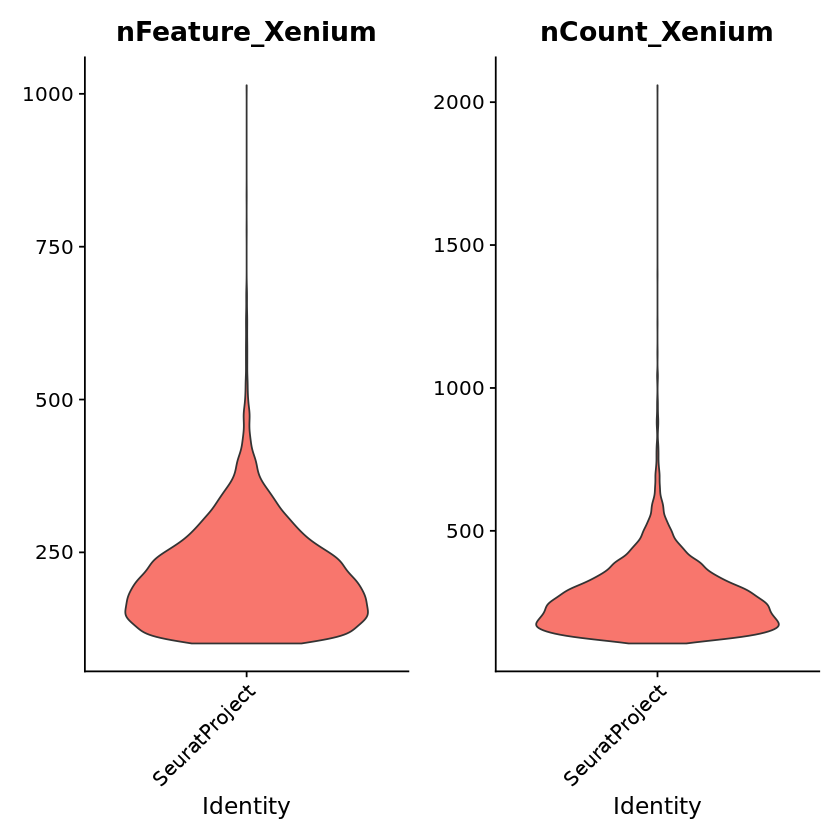

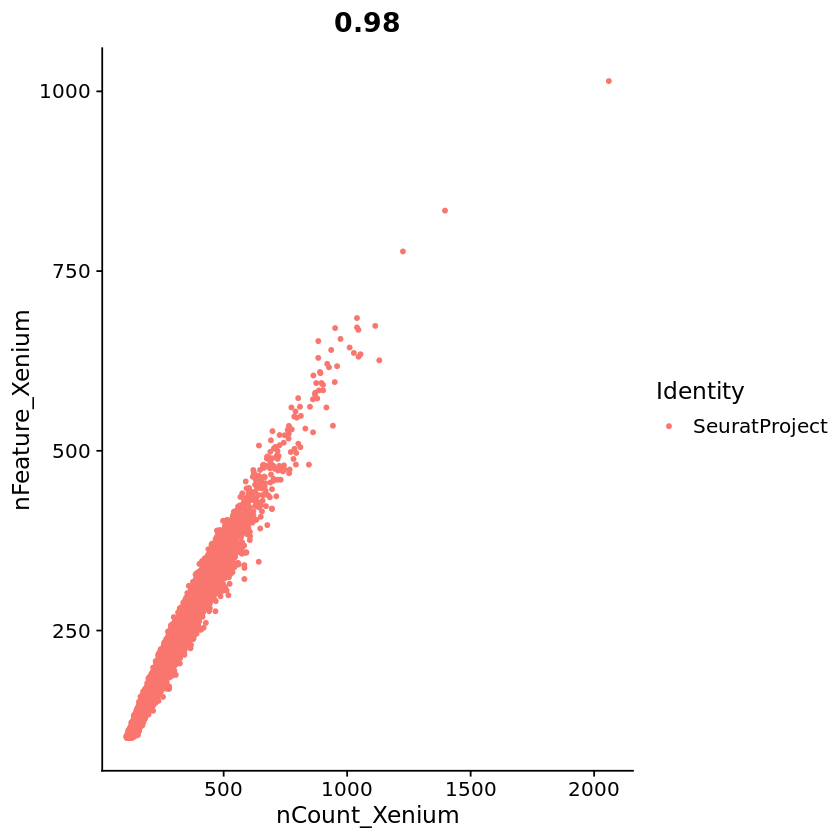

In [4]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

Idents(obj) <- "SeuratProject"
VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [5]:
# Clean everything in case we did the PCA analysis before
obj <- DietSeurat(obj, dimreducs = "spatial")

# Normalize data and calculate cell cycle scores
obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [6]:
# Perform cluster analysis
obj <- FindVariableFeatures(obj, nfeatures = 2000) %>%
        ScaleData(do.scale=FALSE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
        RunPCA(npcs=30) %>%
        RunUMAP(dims = 1:30, min.dist=0.05) %>%
        FindNeighbors(reduction = "pca", dims = 1:30) %>%
        FindClusters(resolution = c(0.1, 0.2, 0.3, 0.5, 0.8))

Regressing out S.Score, G2M.Score

Centering data matrix

PC_ 1 
Positive:  XBP1, MZB1, TENT5C, SLAMF7, DERL3, PIM2, SEL1L, PDIA4, MAN1A1, CD38 
	   CLPTM1L, PDK1, ERN1, RPN1, ATF4, FNDC3B, POU2AF1, P4HB, PECAM1, PRDM1 
	   HYOU1, FKBP11, CLIC4, HOXB7, MANEA, KRTCAP2, DUSP5, IFNAR1, GLCCI1, NUCB2 
Negative:  MS4A1, TNFRSF13C, CIITA, CXCR4, SCIMP, TRAF5, FCMR, SELL, PTPN6, CD82 
	   HIF1A, STAT6, LBH, BCL11A, NLRC5, TUBB, CSK, SESN3, NEK6, STX7 
	   UCP2, RASSF3, RBM38, CCL19, PPP1R9B, DEK, ADAM8, XPO6, SOX2-OT, CYBB 
PC_ 2 
Positive:  TNFRSF13C, CD79A, MS4A1, POU2AF1, OGT, HIF1A, STAT1, TUBB, CIITA, CCDC50 
	   PTPN6, CSK, HIPK2, TAP1, ARF6, PRR13, PPP1R9B, APOBEC3C, PHB2, CD82 
	   SCIMP, IRF1, NEK6, MAPKAPK2, TRAF5, STX7, EIF4G1, ADGRE5, FLII, ITGAL 
Negative:  XBP1, MZB1, TCF21, MYH10, KANK2, ITGB5, EPAS1, NR4A1, FMO3, NBL1 
	   MIPOL1, KITLG, WFDC1, SCN4B, ZBTB16, H19, MYLK, CAVIN2, PI16, LDLR 
	   TRPC6, CFAP47, TPPP3, OSCP1, DKK3, AGER, VGLL3, VEGFD, FHL1, PDE5A 
PC_ 3 
Positive:

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10910
Number of edges: 227460

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9444
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10910
Number of edges: 227460

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8934
Number of communities: 2
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10910
Number of edges: 227460

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8428
Number of communities: 3
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10910
Number of edges: 227460

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7685
Number of communities: 5
Elapsed time: 1 seconds
Modularity Optim

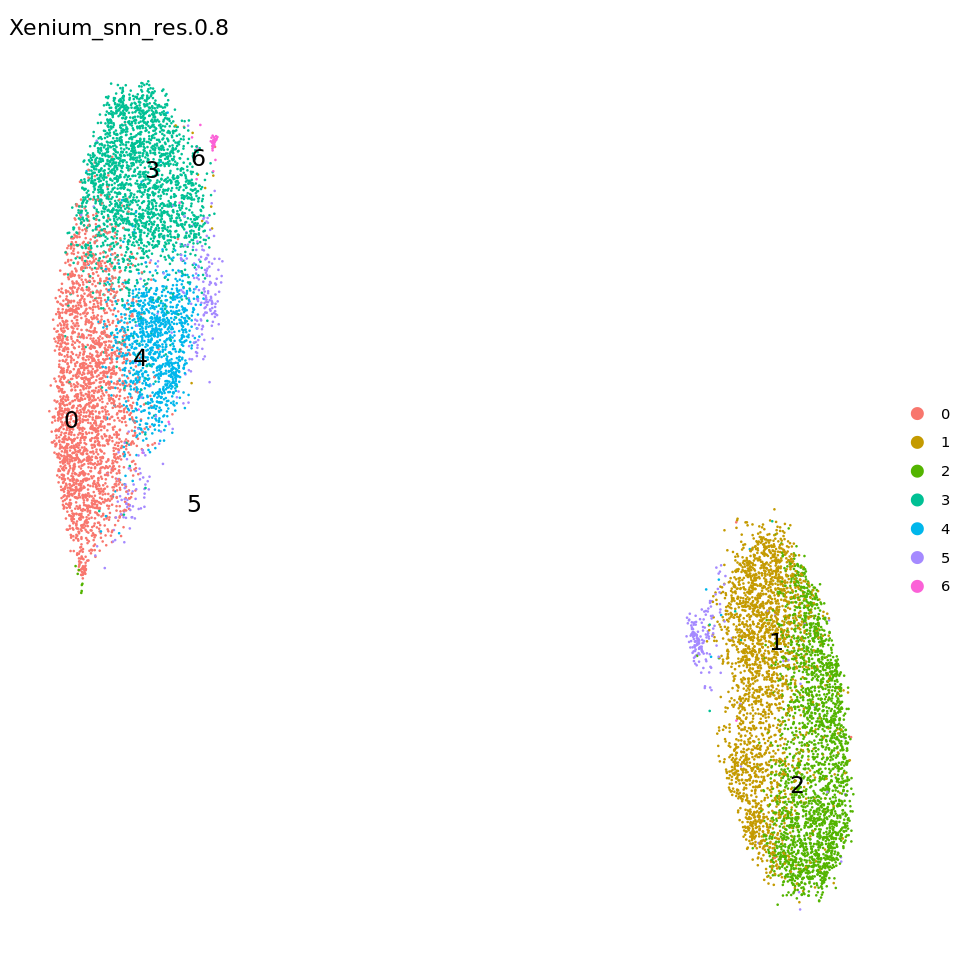

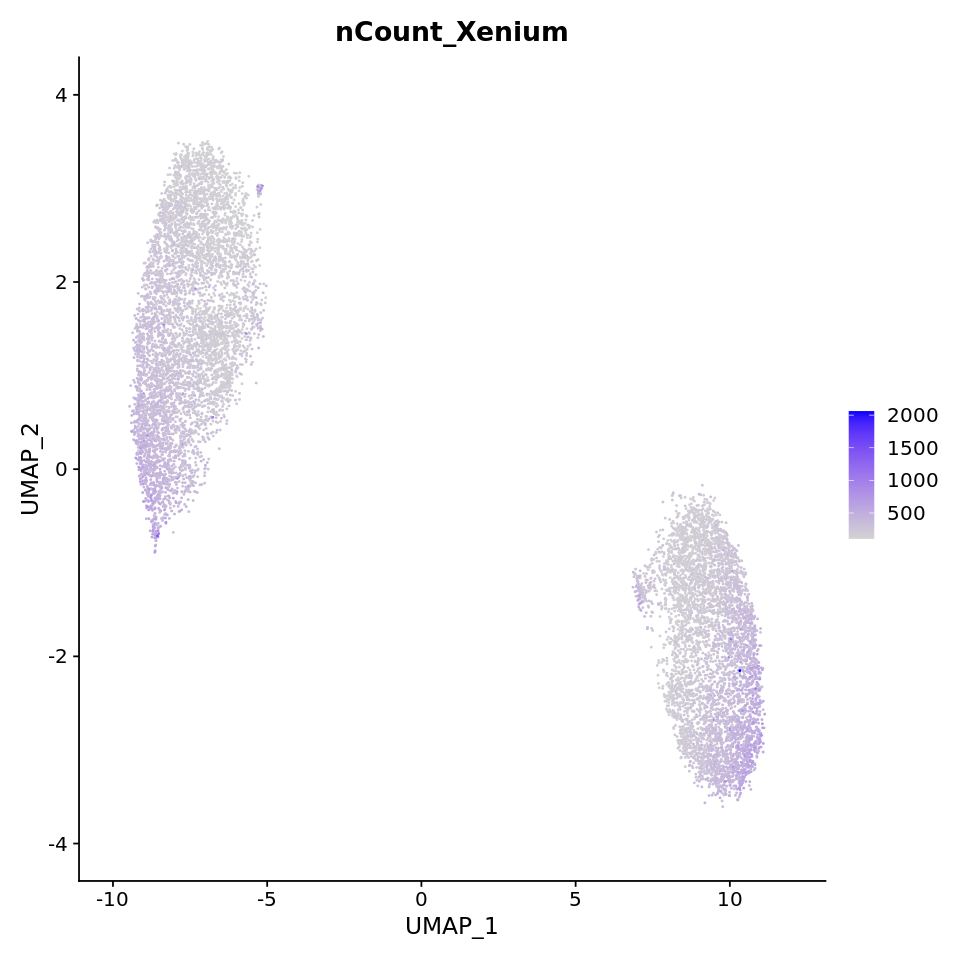

In [7]:
figsize(8, 8)
DimPlot(obj, group.by = "Xenium_snn_res.0.8", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()# + NoLegend()
FeaturePlot(obj, features = "nCount_Xenium")

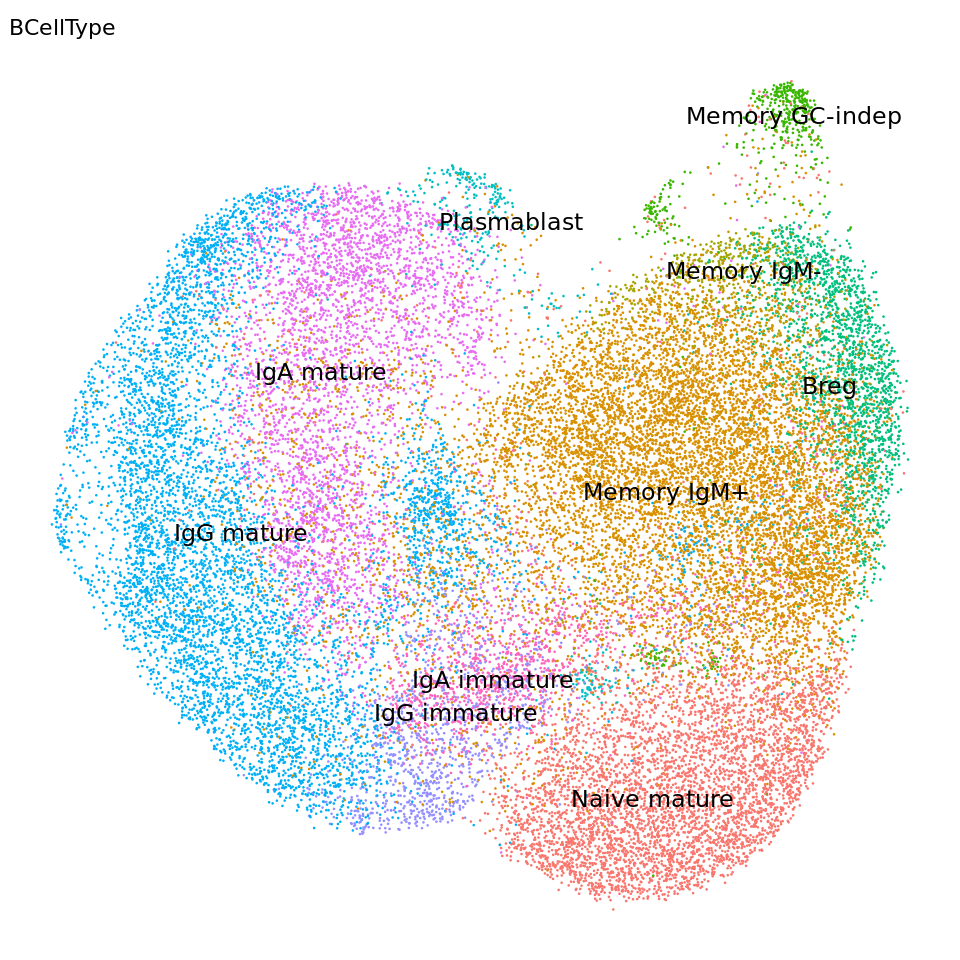

In [8]:
# Subtype annotation in reference dataset (PanCancer atlas)
figsize(8, 8)
DimPlot(pancancer_sc, group.by = "BCellType", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()+ NoLegend()

## Seurat Integration
Credit: Sam

In [9]:
# Clean the spatial data
DefaultAssay(obj) <- "Xenium"
# DefaultAssay(pancancer_sc) <- "RNA"
obj$Batch <- "Xenium"
pancancer_sc$Batch <- "Single-cell"

In [10]:
# Get the common genes between the two datasets
common_genes <- rownames(obj)[rownames(obj) %in% rownames(pancancer_sc)]
pancancer_sc <- pancancer_sc[common_genes, ]

In [11]:
# Create query subset
obj.query <- obj
obj.query <- obj.query[common_genes, ]

# Create reference dataset
obj.ref <- pancancer_sc
obj.ref <- RunPCA(obj.ref, npcs=30, verbose = F)
obj.ref$BCellType <- factor(obj.ref$BCellType)

In [12]:
obj.ref
obj.query

An object of class Seurat 
1336 features across 31928 samples within 2 assays 
Active assay: integrated (668 features, 668 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
668 features across 10910 samples within 1 assay 
Active assay: Xenium (668 features, 406 variable features)
 2 dimensional reductions calculated: pca, umap

In [13]:
options(future.globals.maxSize= 6000*1024^2)

obj.query <- NormalizeData(obj.query)
obj.anchors <- FindTransferAnchors(reference = obj.ref,
                                        query = obj.query,
                                        dims = 1:30,
                                        reference.reduction = "pca")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 16370 anchors

Filtering anchors

	Retained 4034 anchors



In [14]:
predictions <- TransferData(anchorset = obj.anchors, refdata = obj.ref$BCellType, dims = 1:30)
obj.query <- AddMetaData(obj.query, metadata = predictions)

Finding integration vectors



Finding integration vector weights

Predicting cell labels



In [15]:
options(scipen = 999)
table(obj.query$predicted.id)
round(100*prop.table(table(obj.query$predicted.id)), 2)
round(100*prop.table(table(obj.ref$BCellType)), 2)


           Breg    IgA immature      IgA mature    IgG immature      IgG mature 
            627              46            1747               1            2981 
Memory GC-indep     Memory IgM-     Memory IgM+    Naive mature     Plasmablast 
             15               8            4981             475              29 


           Breg    IgA immature      IgA mature    IgG immature      IgG mature 
           5.75            0.42           16.01            0.01           27.32 
Memory GC-indep     Memory IgM-     Memory IgM+    Naive mature     Plasmablast 
           0.14            0.07           45.66            4.35            0.27 


   Naive mature     Memory IgM+     Memory IgM- Memory GC-indep            Breg 
          16.29           32.66            1.67            1.69            6.17 
    Plasmablast      IgG mature    IgG immature      IgA mature    IgA immature 
           1.12           20.81            3.73           12.14            3.72 

In [16]:
obj.ref <- RunUMAP(obj.ref, dims = 1:30, reduction = "pca", return.model = TRUE)
obj.query <- MapQuery(anchorset = obj.anchors, reference = obj.ref, query = obj.query,
    refdata = list(celltype = "BCellType"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

17:33:55 UMAP embedding parameters a = 0.9922 b = 1.112



17:33:55 Read 31928 rows and found 30 numeric columns

17:33:55 Using Annoy for neighbor search, n_neighbors = 30

17:33:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:33:58 Writing NN index file to temp file /tmp/Rtmpehg1By/file2d571b73e37a55

17:33:58 Searching Annoy index using 1 thread, search_k = 3000

17:34:14 Annoy recall = 99.95%

17:34:14 Commencing smooth kNN distance calibration using 1 thread

17:34:15 Initializing from normalized Laplacian + noise

17:34:16 Commencing optimization for 200 epochs, with 1410730 positive edges

17:34:37 Optimization finished

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning messag

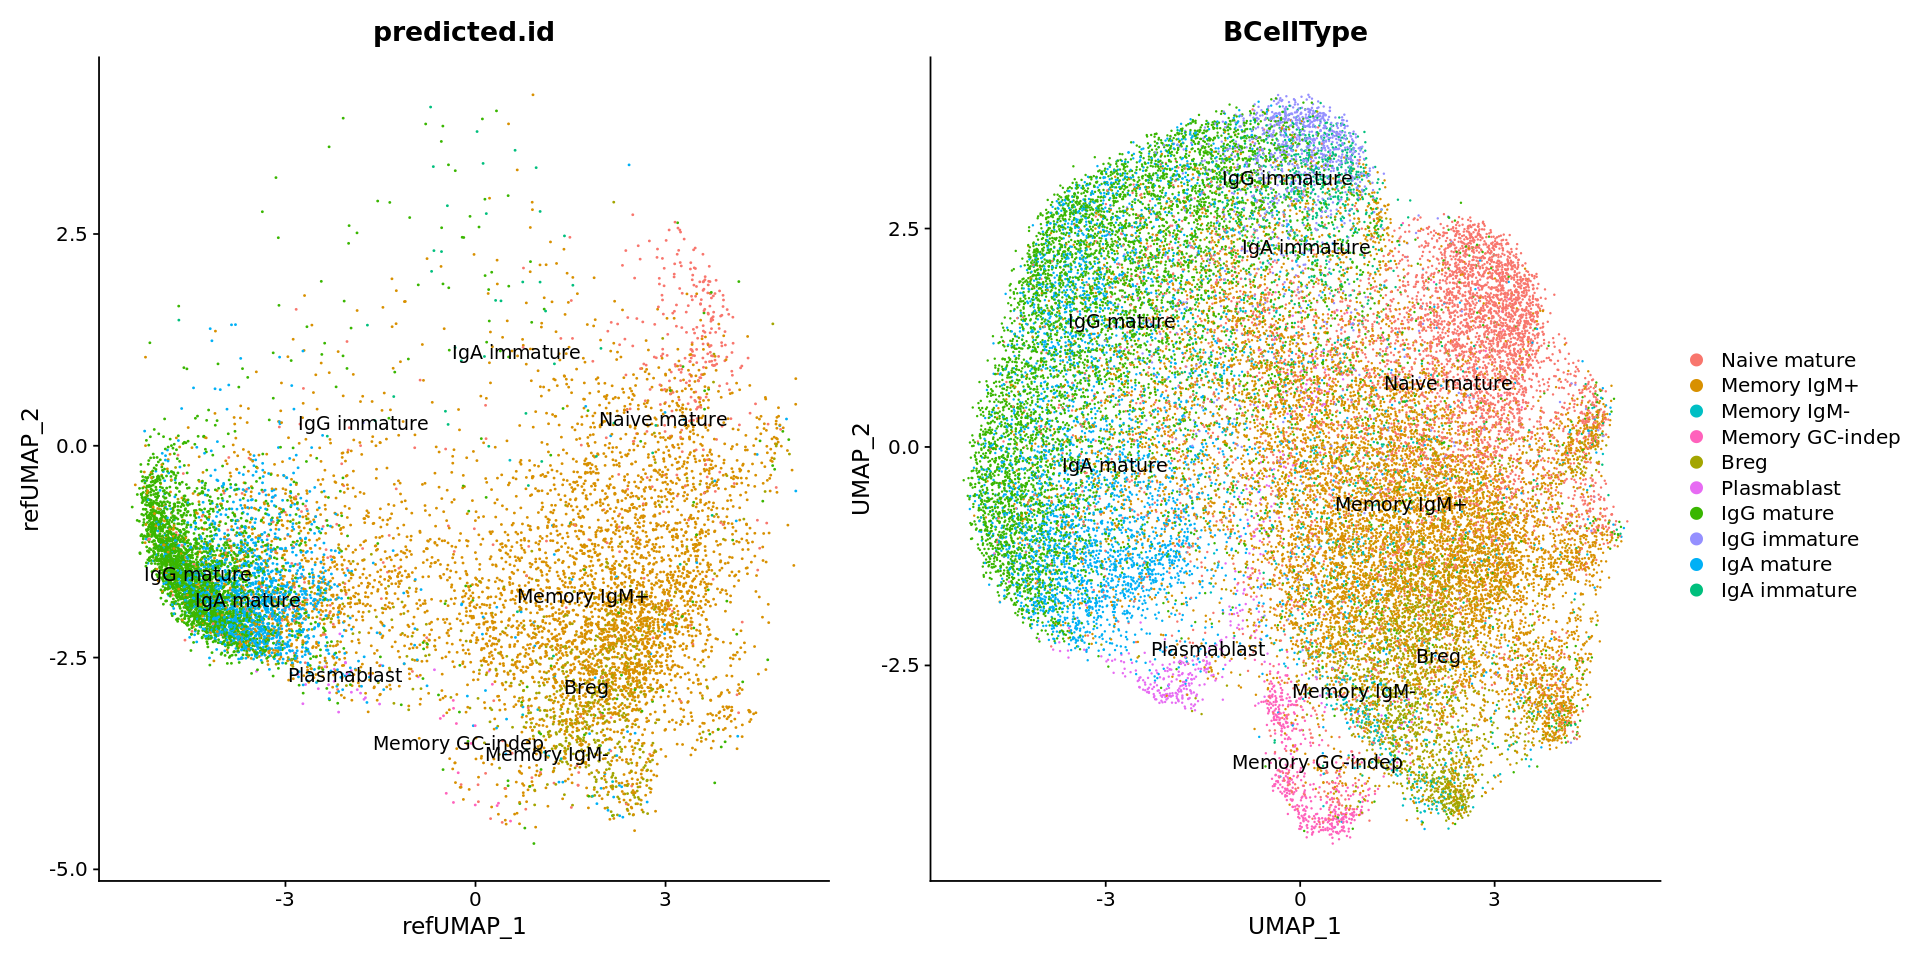

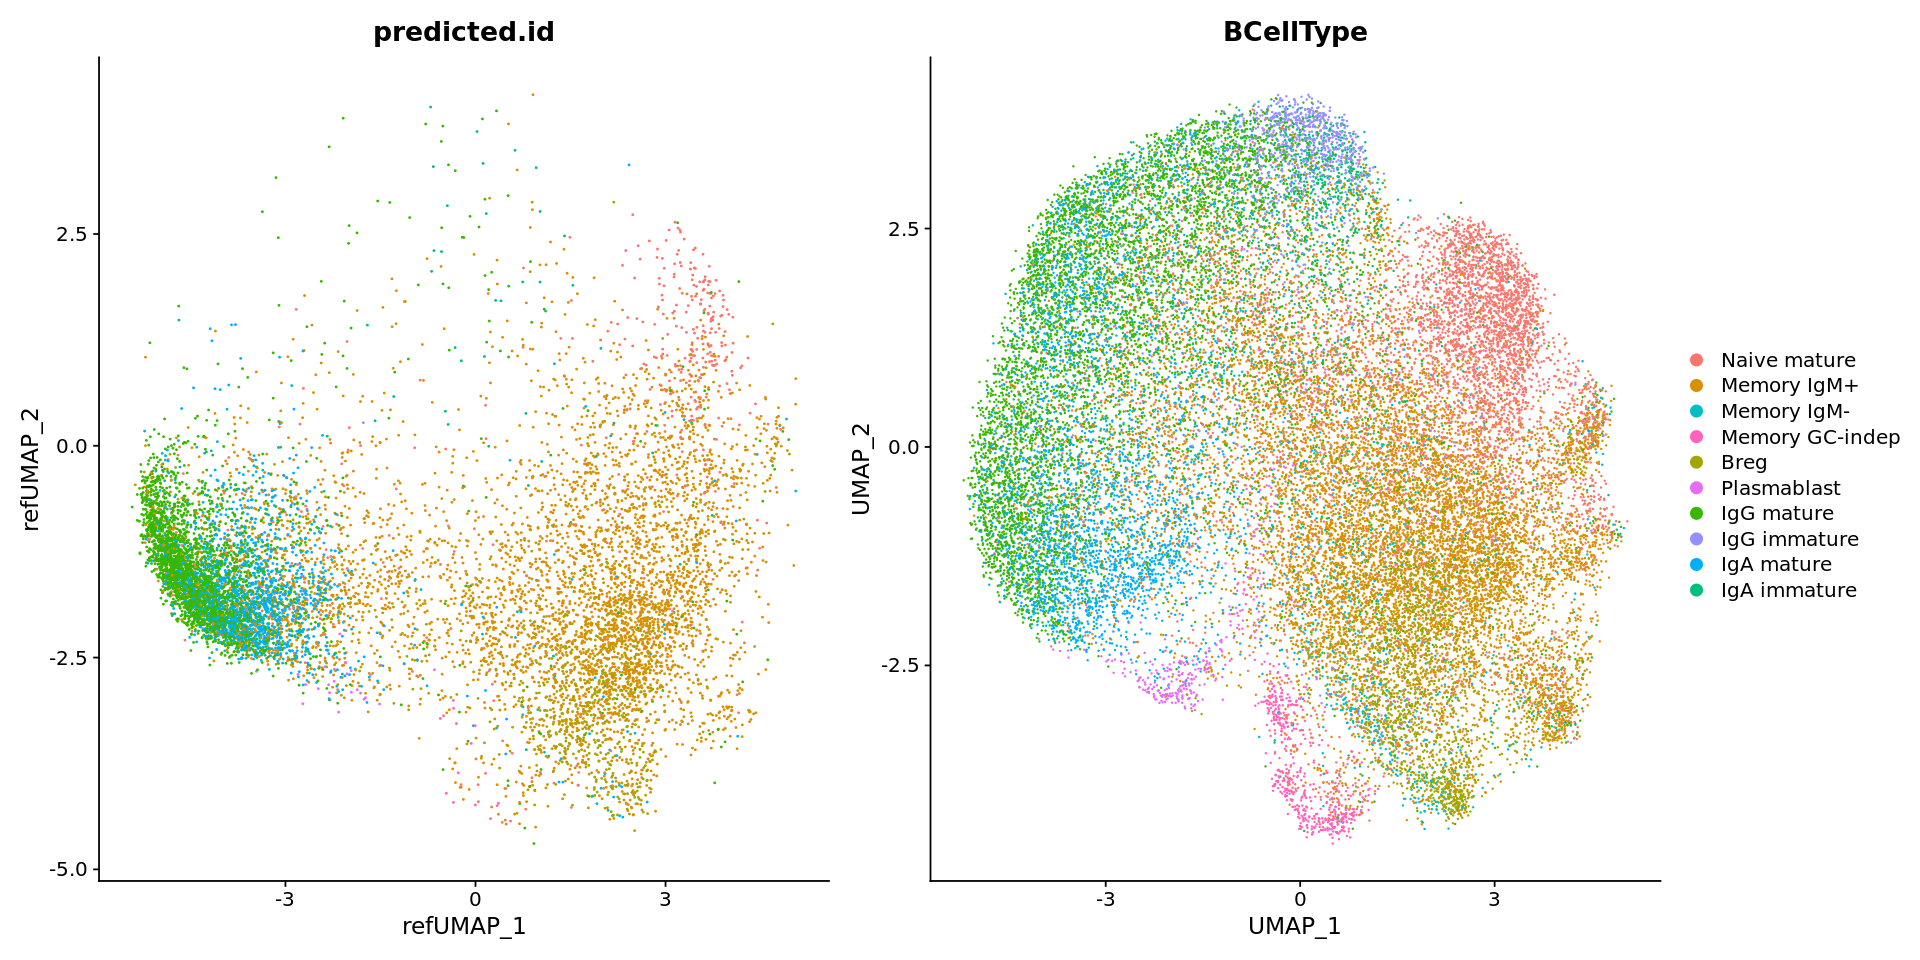

In [17]:
dd.col <- hue_pal()(length(unique(pancancer_sc$BCellType)))
names(dd.col) <- unique(pancancer_sc$BCellType)

figsize(16, 8)
(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id", label=TRUE) + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="BCellType", label=TRUE, repel = TRUE) & 
    scale_color_manual(values = dd.col) 

(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id") + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="BCellType") & 
    scale_color_manual(values = dd.col)

In [27]:
saveRDS(obj.query, file.path(dir, "BC_query.rds"))
saveRDS(obj.ref, file.path(dir, "BC_ref.rds"))

## Validate annotation - heatmap

In [7]:
obj.query <- readRDS(file.path(dir, "BC_query.rds"))
obj.ref <- readRDS(file.path(dir, "BC_ref.rds"))

In [ ]:
Idents(obj) <- obj$`Xenium_snn_res.0.8`
markers <- FindAllMarkers(obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.5)
write.csv(markers, file = paste0(dir, "/FindAllMarkers_BC.csv"), row.names = FALSE)

In [18]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")

BC_gene_list <- list('BC' = c("TCL1A", "IL4R", "FCER2", "MS4A1", "CD19", "IL12A", "CD27", "TGFB1", "TGFB3", "EBI3", "IL6", "CD274", 
                            "IGHM", "RFTN1", "CD38", "RGS13", "NEIL1", "CDCA7", "GZMB", "MME", "FCRL4", "PDCD1", "ITGAX", "CXCR3", 
                            "CCR2", "IRF4", "PRDM1", "TOP2A", "MKI67", "HLA-A", "MZB1", "SDC1", "IGHG2", "IGHG3", "XBP1", "IFNG", "IGHD", "IGHA1", "IGHA2",
                            "IGBP1", "IGF1", "IGF1R", "IGF2BP1", "IGF2BP2", "IGF2BP3", "IGF2R", "IGFBP1", "IGFBP2", "IGFN1", "IGHE", "IGSF1", 
                            "IGSF3", "IGSF8", "IGSF9B"
                            ))

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(idents)

  # Now:
  data %>% select(all_of(idents))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


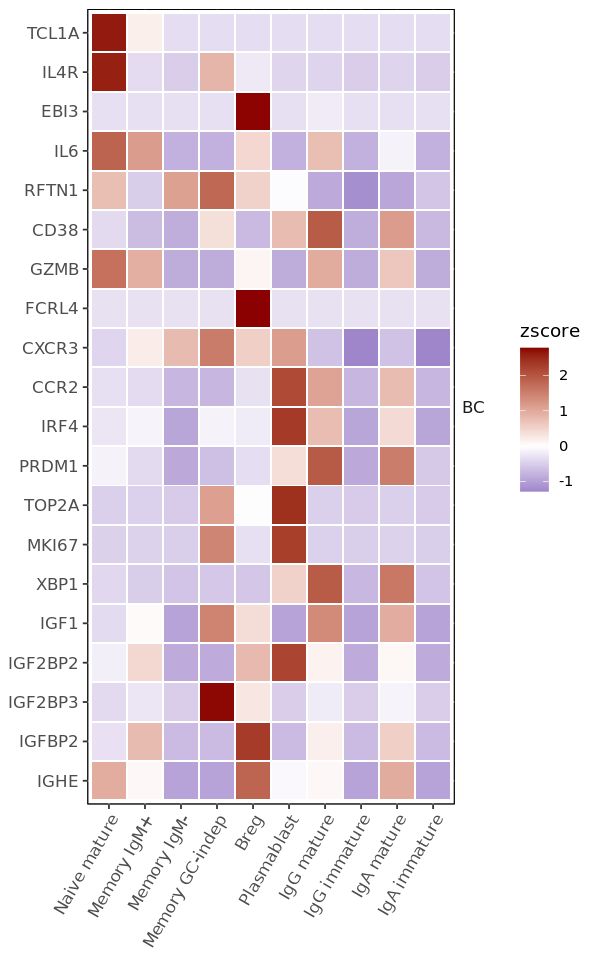

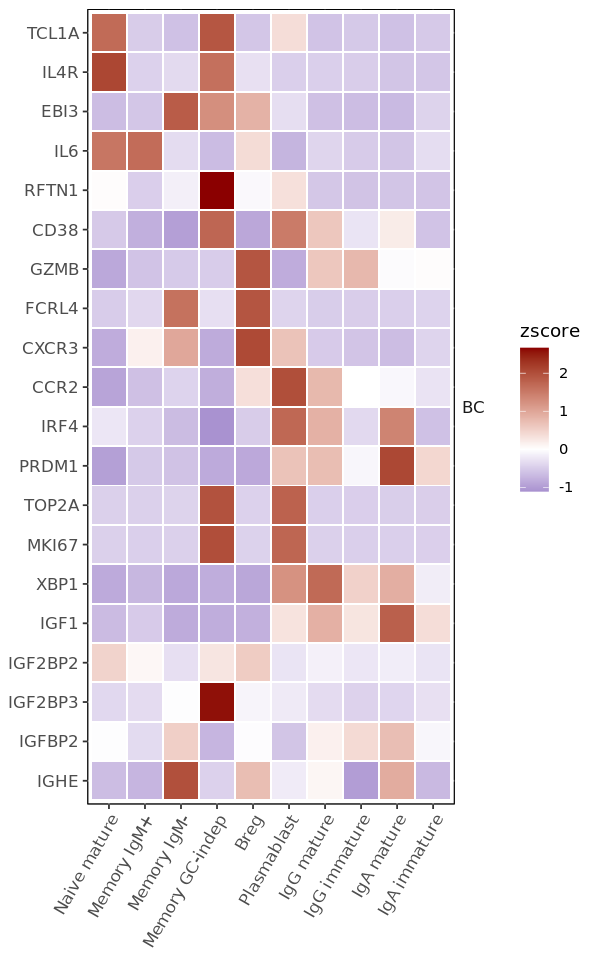

In [19]:
figsize(5, 8)
# obj.query$cluster_rename <- paste0("cluster_", obj.query$`Xenium_snn_res.0.8`)
# heatmap(obj.query, genes = BC_gene_list, assay = "Xenium", group.by = "cluster_rename")
obj.query$predicted.id <- factor(obj.query$predicted.id, levels = levels(pancancer_sc$BCellType))
heatmap(obj.query, genes = BC_gene_list, assay = "Xenium", group.by = "predicted.id")
heatmap(pancancer_sc, genes = BC_gene_list, assay = "RNA", group.by = "BCellType")